In [10]:
import torch
from datasets import Features, Value, load_dataset, Sequence
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer, TrainingArguments, EvalPrediction
from fuzzywuzzy import fuzz
import re
import os
from dotenv import load_dotenv
import logging
import time
from adapters import AutoAdapterModel, AdapterTrainer, LlamaAdapterModel
import sys
import pandas as pd
import itertools
import gc

logging.basicConfig(level=logging.INFO)
load_dotenv()

ACCESS_TOKEN = os.getenv("HUGGINGFACE_API_KEY")
MODEL_DIR = os.getcwd() + "/models"
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
DATASET_DIR = os.getenv("DATASET_DIR") + "FinQA/dataset/"
RESULTS_DIR = os.getenv("RESULTS_DIR") + "FinQA/"
SIMILARITY_THRESHOLD = 85  
RESULTS_HEADER = ["model", "experiment", "trained_samples", "epochs", "batch_size", "evaluated_samples", "accuracy", "avg_similarity", "total_time", "avg_time_per_sample", "training_time"]
# Other possible headers: "similarity_threshold", "max_new_tokens", etc.

EXPERIMENT = "adapter" # "adapter" or "baseline"

def preprocess_to_finetune(batch):
    prompt = batch["input_text"]
    answer = batch["expected_answer"]
    full_text = [p+a for p, a in zip(prompt, answer)]


    full_text_encodings = tokenizer(full_text, return_tensors="pt", padding=True, truncation=True)

    prompt_encodings = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    prompt_len = prompt_encodings["input_ids"].shape[1] # One length is enough if padding + truncation

    labels = full_text_encodings["input_ids"].clone()
    labels[:, :prompt_len] = -100 # Ignore loss on prompt tokens?

    full_text_encodings["labels"] = labels # Tokenized_full has input_ids, attention_mask, labels

    return  full_text_encodings
    # encoded = tokenizer(batch["input_text"], truncation=True, padding=True)
    # return  encoded
    
def load_model(model_id, device, token, cache_dir):
    logging.info(f"Loading model {model_id} on device {device}")
    # Define 4-bit quantization configuration
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Enable 4-bit quantization
        bnb_4bit_compute_dtype=torch.float16,  # Use FP16 for computation
        bnb_4bit_use_double_quant=True,  # Double quantization for better memory efficiency
        bnb_4bit_quant_type="nf4"  # NormalFloat4, best for Llama models
    )
    # Load tokenizer and model
    if EXPERIMENT == "adapter":
        model = LlamaAdapterModel.from_pretrained(
            model_id,
            device_map={"": device},
            quantization_config=quant_config,
            cache_dir=cache_dir,
            torch_dtype=torch.bfloat16,
        )
        model.gradient_checkpointing_enable()  # Enable gradient checkpointing
    elif EXPERIMENT == "baseline":
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map={"": device},
            quantization_config=quant_config,
            cache_dir=cache_dir,
            torch_dtype=torch.bfloat16,
        )
    else:
        raise ValueError(f"Unknown experiment type thus can't decide model: {EXPERIMENT}")
    
    tokenizer = AutoTokenizer.from_pretrained(
        model_id, 
        token=token,
        cache_dir=cache_dir
    )

    tokenizer.pad_token = tokenizer.eos_token # For padding in batch

    return model, tokenizer

def preprocess_function(example):
    # TODO: should raise error or warning when absent
    question = example["qa"].get("question", "No question available.")
    expected_answer = str(example['qa'].get("answer", "")).strip()
    table = example.get("table", [])
    table_str = "\n".join([" | ".join(row) for row in table])

    pre_text = " ".join(example.get("pre_text", []))
    post_text = " ".join(example.get("post_text", []))

    input_text = (
        "You are a financial calculator. Follow these steps:\n"
        "Return ONLY the final numerical or boolean answer with no text explanation\n\n"
        f"Pre Text Data:\n{pre_text}\n\n"
        f"Table Data:\n{table_str}\n\n"
        f"Post Text Data:\n{post_text}\n\n"
        f"Question: {question}\n"
        "Final Answer (number only): "
    )

    return {
        "input_text": input_text,
        "expected_answer": expected_answer
    }

def load_preprocessed_dataset(path: str, data_files: str, split: str):
    logging.info("Loading dataset")
    dataset = load_dataset(
        path,
        data_files=data_files,
        split=split
    )

    logging.info("Preprocessing dataset")
    dataset = dataset.map(preprocess_function, remove_columns=dataset.column_names)
    dataset = dataset.with_format("torch")  # Use lazy loading
    return dataset

def generate_answer(input_text, tokenizer: AutoTokenizer, model: AutoModelForCausalLM):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(DEVICE)
    input_ids = inputs["input_ids"]

    with torch.no_grad():
        outputs = model.generate(**inputs, temperature=0.1, top_k=10, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(outputs[:, input_ids.shape[-1]:][0], skip_special_tokens=True)

    return generated_text

def clean_answer(text):
    
    # TODO: Add more extracting logic here
    # Extract only the answer part from generated text
    if "Answer:" in text:
        text = text.split("Answer:")[-1].strip()

    # TODO: Add tolerance relative to the size of the number
    # Handle percentage
    percent_match = re.search(r'[-+]?\d*\.?\d+\s*%', text)
    if percent_match:
        number = float(percent_match.group(0).replace('%', '').strip())
        return f"{round(number, 0)}%"

    # TODO: Add tolerance relative to the size of the number
    # Handle regular numbers
    decimal_match = re.search(r'[-+]?\d*\.?\d+', text, re.MULTILINE)
    if decimal_match:
        number = float(decimal_match.group(0))
        # If it's close to an integer, round it
        if abs(round(number) - number) < 0.01:
            return str(round(number))
        # Otherwise, round to one decimal place
        return str(round(number, 0))

    # Handle yes/no answers
    text = text.lower().strip()
    if 'yes' in text or 'true' in text:
        return 'yes'
    if 'no' in text or 'false' in text:
        return 'no'

    return text.strip()


    

cuda


In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID, 
    cache_dir=MODEL_DIR,
)
tokenizer.pad_token = tokenizer.eos_token # For padding in batch

train_dataset = load_preprocessed_dataset("json", data_files=DATASET_DIR+"/train.cleaned.json", split="train")
train_dataset = train_dataset.map(preprocess_to_finetune, batched=True, batch_size=1)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], device=DEVICE) 

INFO:root:Loading dataset
INFO:root:Preprocessing dataset
Map: 100%|██████████| 6251/6251 [00:34<00:00, 179.33 examples/s]


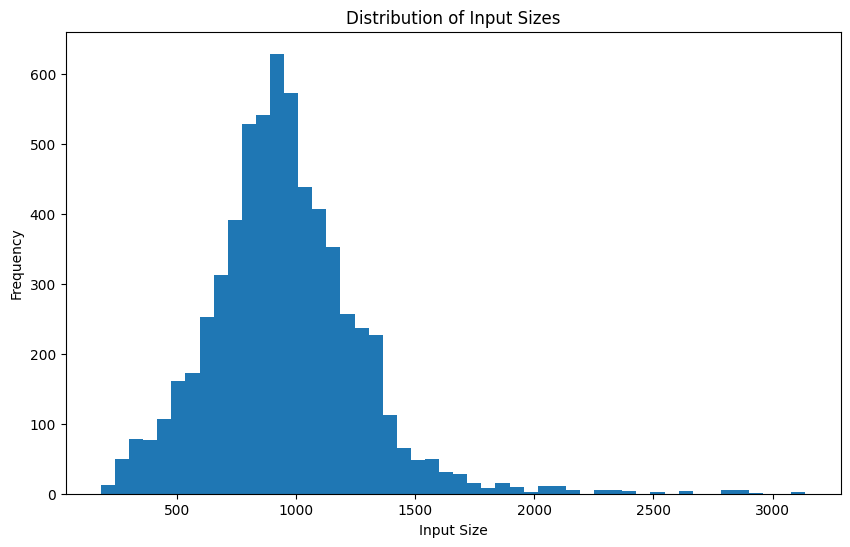

In [12]:
import matplotlib.pyplot as plt
input_sizes = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]

plt.figure(figsize=(10, 6))
plt.hist(input_sizes, bins=50)
plt.xlabel("Input Size")
plt.ylabel("Frequency")
plt.title("Distribution of Input Sizes")
plt.show()

In [17]:
idx = 65
print(f"Size of input at index {idx}: {len(train_dataset[idx]['input_ids'])}")

max_idx = input_sizes.index(max(input_sizes))
print(f"Max input size: {max(input_sizes)} at index {max_idx}")


Size of input at index 65: 1887
Max input size: 3138 at index 2249


In [1]:
import pandas as pd

df = pd.read_csv("./results/FinQA/results.tsv", sep="\t")
display(df[["experiment", "trained_samples", "epochs", "batch_size", "accuracy"]])

,experiment,trained_samples,epochs,batch_size,accuracy
0,baseline,0,0,0,54.55
1,adapter,1,1,1,0.00
2,adapter,1,5,1,0.00
3,adapter,1,15,1,0.00
4,adapter,1,1,2,0.00
5,adapter,1,5,2,0.00
6,adapter,1,15,2,0.00
7,adapter,1,1,4,0.00
8,adapter,1,5,4,0.00
9,adapter,1,15,4,0.00


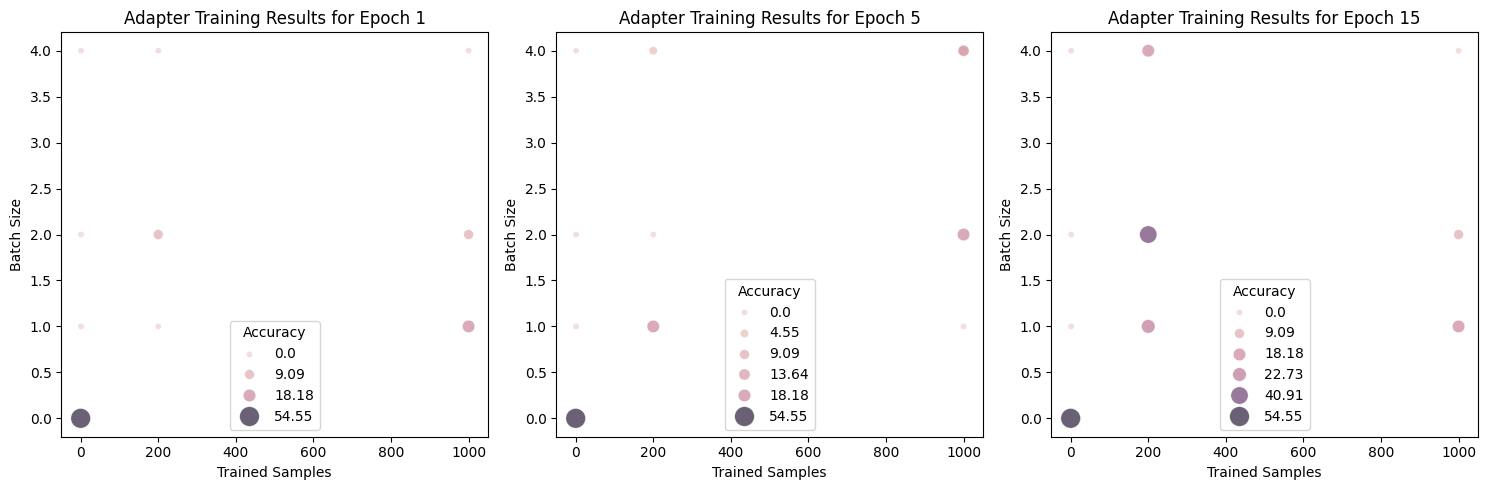

In [21]:
# Visualise the results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

experiments_df = df[df["experiment"] == "adapter"]

# visualise each epoch separately
fig, axes = plt.subplots(1, len(experiments_df["epochs"].unique()), figsize=(15, 5))
for i, epoch in enumerate(experiments_df["epochs"].unique()):
    epoch_df = pd.concat([experiments_df[experiments_df["epochs"] == epoch], df[df["experiment"] == "baseline"]])
    sns.scatterplot(data=epoch_df, x="trained_samples", y="batch_size", hue="accuracy", size="accuracy", sizes=(20, 200), ax=axes[i], alpha=0.7)
    axes[i].set_title(f"Adapter Training Results for Epoch {epoch}")
    axes[i].set_xlabel("Trained Samples")
    axes[i].set_ylabel("Batch Size")
    axes[i].legend(title="Accuracy")
plt.tight_layout()
plt.show()

